In [63]:
import sdeint
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
from scipy.stats import gaussian_kde
from hmmlearn import hmm
import warnings
warnings.filterwarnings("ignore") ## hmm throws warnings about old functions used internally...
from matplotlib.patches import Ellipse
import numpy.linalg as la
# from scipy.spatial import distance_matrix
# from diffusion_maps import run_diffusion_map_dense

# Helping functions

In [138]:
def run_SDE(dU, T = 2000., timesteps = 200001):
    B = np.diag([1.,1.]) # diagonal, so independent driving Wiener processes
    tspan = np.linspace(0.0, T, timesteps)
    x0 = np.array([0.,0.])

    def f(x, t):
        return np.asarray(dU(*x))

    def G(x, t):
        return B

    result = sdeint.itoint(f, G, x0, tspan,normalized=False)
    plt.scatter(*result.T,s=0.05, c = 'black',edgecolors='none')
    
    return result

In [139]:
def run_hmm(result,n_clusters = 30):
    hmm_expects_model = hmm.GaussianHMM(n_components=n_clusters,covariance_type='full')
    hmm_expects_model.fit(result)
    return hmm_expects_model

In [140]:
def sorted_eigs(e_vals,e_vecs):
    ## Then sort the eigenvectors and eigenvalues s.t. the eigenvalues monotonically decrease.
    l = zip(e_vals,e_vecs.T)
    l = sorted(l,key = lambda z: -z[0])
    return np.asarray([el[0] for el in l]),np.asarray([el[1] for el in l]).T

In [141]:
def ellipses_plot(result,hmm_model,indices = [0,1],std_dev = 1.):

    covariances = np.asarray([[[hmm_model.covars_[clus,n,m] 
                                for n in indices] 
                                    for m in indices]
                                        for clus in range(n_clusters)])
    means = np.asarray([[hmm_model.means_[clus,n] 
                                for n in indices] 
                                    for clus in range(n_clusters)])


    sorted_eig_lst = [sorted_eigs(*la.eig(cov)) for cov in covariances]

    angles = np.rad2deg(np.asarray([np.arctan2(*v[1][:,0]) for v in sorted_eig_lst]))
    widths = [2*std_dev*np.sqrt(v[0][0]) for v in sorted_eig_lst]
    heights = [2*std_dev*np.sqrt(v[0][1]) for v in sorted_eig_lst]

    es = [Ellipse(xy=mean, width=width, height=height, angle=angle,
                  edgecolor='black', facecolor='none',linewidth = 1)
             for mean,width,height,angle in zip(means,widths,heights,angles) ]

    fig = plt.figure(0)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )
    ax.set_title("coordinates "+str(indices[0]+1)  +","+str(indices[1]+1) )

    for e in es:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_clip_box(ax.bbox)
    
    x = result.T[0]
    y = result.T[1]

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig = plt.figure(0,)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )

    ax.scatter(x, y, c=np.log(z), s=10, edgecolor='')

In [142]:
def hmm_with_sub_sample(subsampling = 50):
    sampled_result = result[::subsampling]
    hmm_expects_model = run_hmm(sampled_result,n_clusters)
    ellipses_plot(sampled_result,hmm_expects_model)
    plt.axis('equal')
    return hmm_expects_model

# Analysis starts here

In [186]:
x1, x2, d = sympy.symbols('x1 x2 d')

In [187]:
d = 1. ## maybe we would like to introduce dependence on distance between wells later

In [201]:
n_clusters = 30      #### Number of clusters for the HMMs
T = 2000.            #### Time for simulation
timesteps = 200001   #### Total number of points in a trajectory

## Single well potential

In [190]:
U = -(4.*x1**2 + 25./2*x2**2)/5

(0, 1.8)

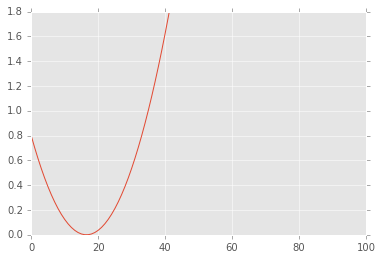

In [191]:
## Potential along x1
U_ = lambda x: sympy.lambdify([x1,x2],U)(x,0)
plt.plot(-U_(np.linspace(-1,5,100)))
plt.ylim(0,1.8)

# Testing different HMMs:

## subsampling trajectories of various lengths, such that the total number of points is fixed.

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

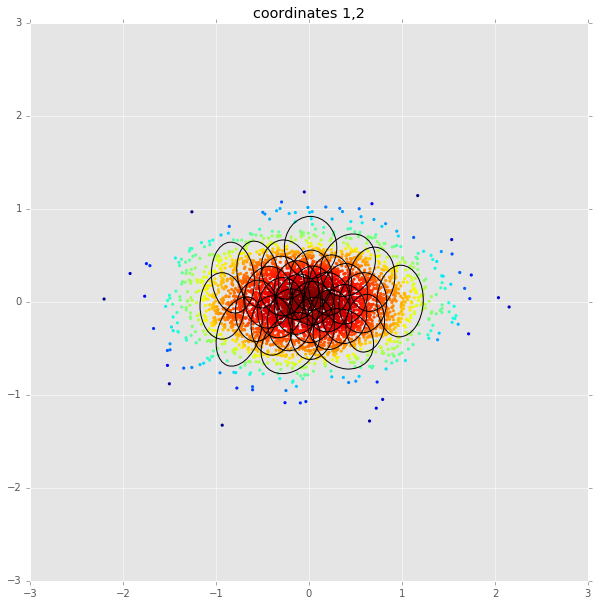

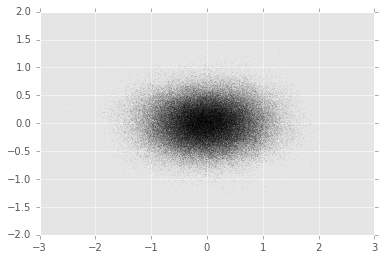

In [171]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
hmm_with_sub_sample(50)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

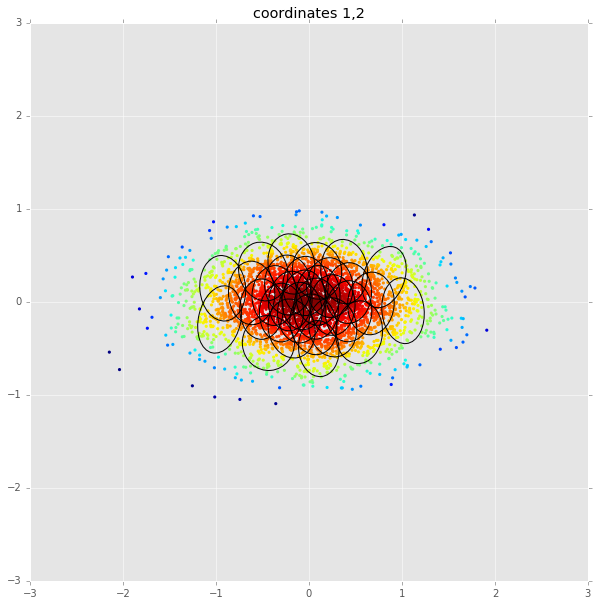

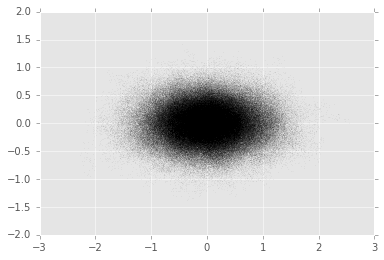

In [172]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps*2)
hmm_with_sub_sample(100)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

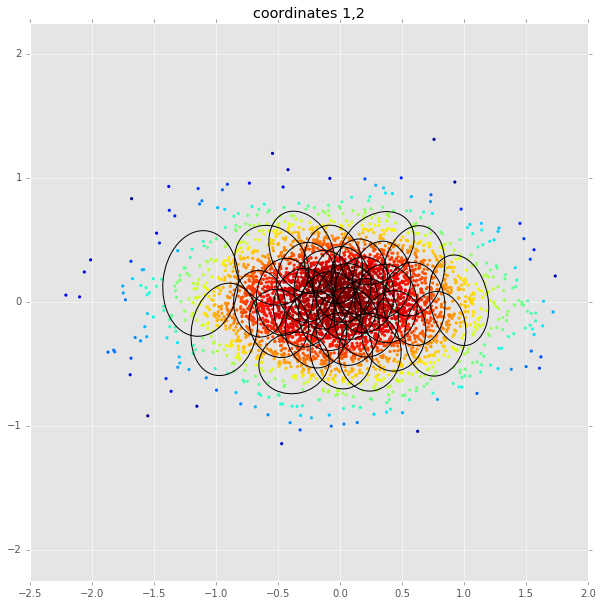

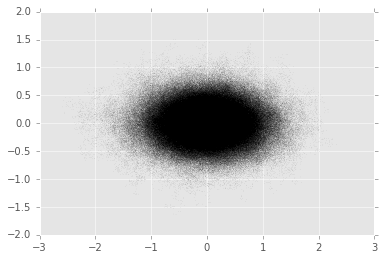

In [173]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps*4)
hmm_with_sub_sample(200)

## Subsampling the same trajectory with different number of points.

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

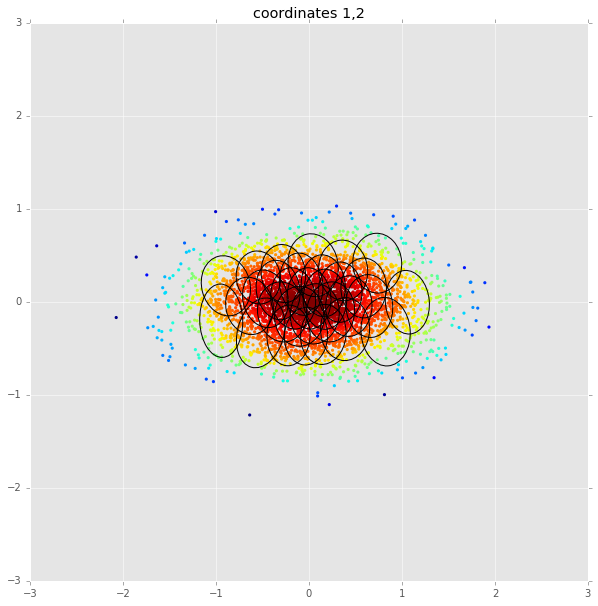

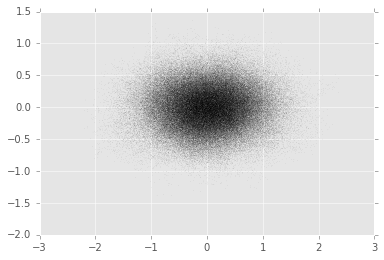

In [192]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
hmm_with_sub_sample(50)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

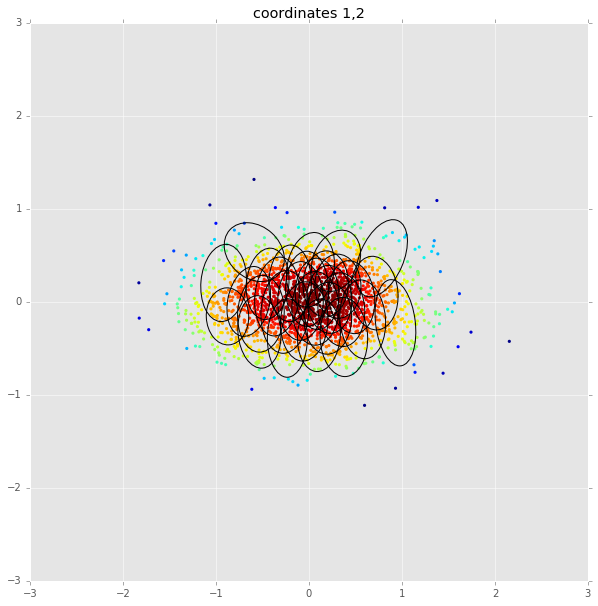

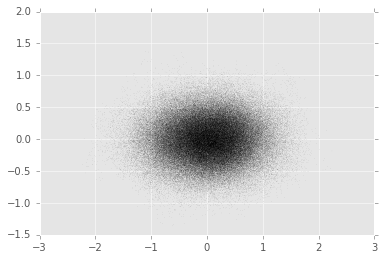

In [193]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
hmm_with_sub_sample(100)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

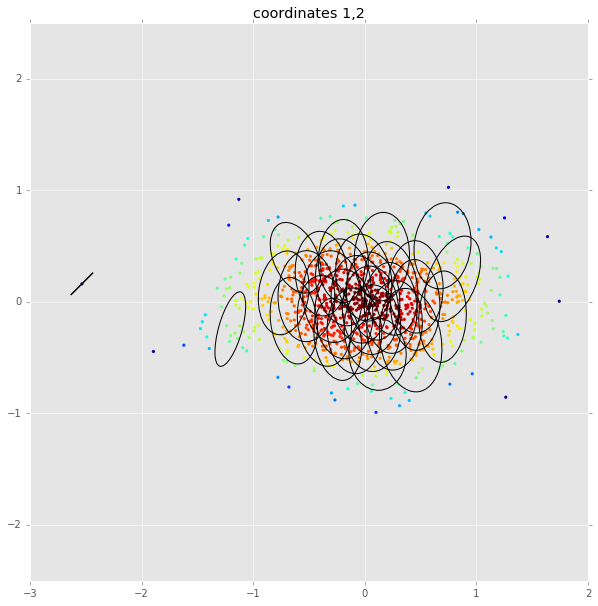

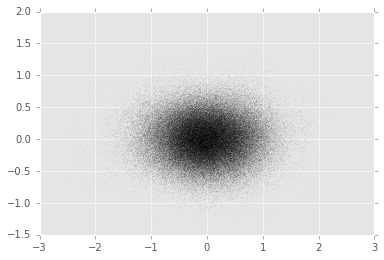

In [194]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
hmm_with_sub_sample(200)

In [195]:
## used MINUS the potential for convenience later
## example from https://arxiv.org/pdf/math/0503445.pdf page 14.
rescale = 1.
U = -(1./4 * (x1/rescale)**4 - 25./12*(x1/rescale)**3 + 9./2 *(x1/rescale)**2 + 25./2*x2**2)/5

(0, 1.8)

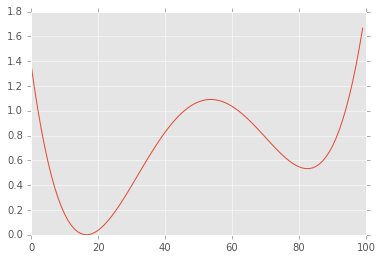

In [196]:
## Potential along x1
U_ = lambda x: sympy.lambdify([x1,x2],U)(x,0)
plt.plot(-U_(np.linspace(-1,5,100)))
plt.ylim(0,1.8)

## subsampling trajectories of various lengths, such that the total number of points is fixed.

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

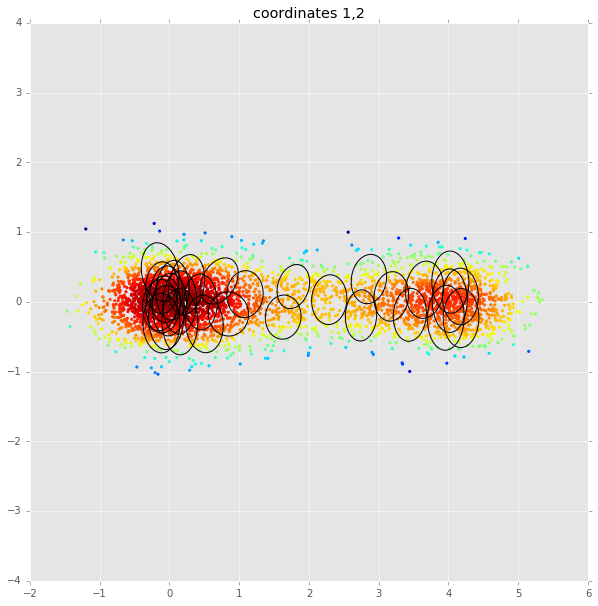

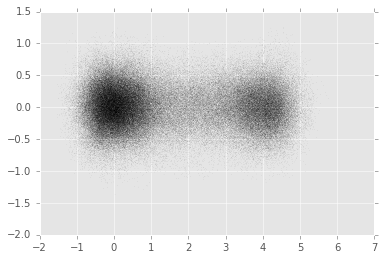

In [197]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
hmm_with_sub_sample(50)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

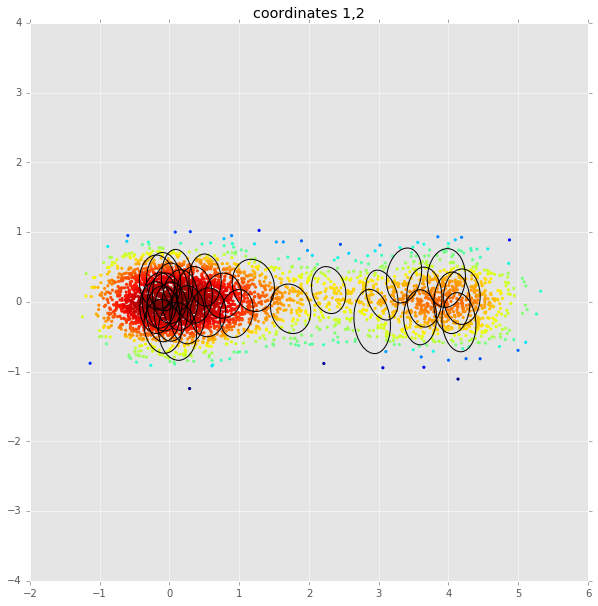

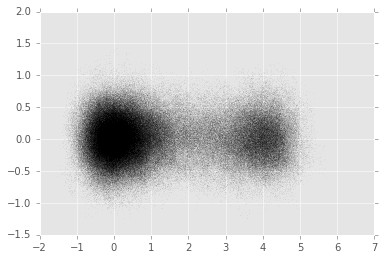

In [177]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps*2)
hmm_with_sub_sample(100)

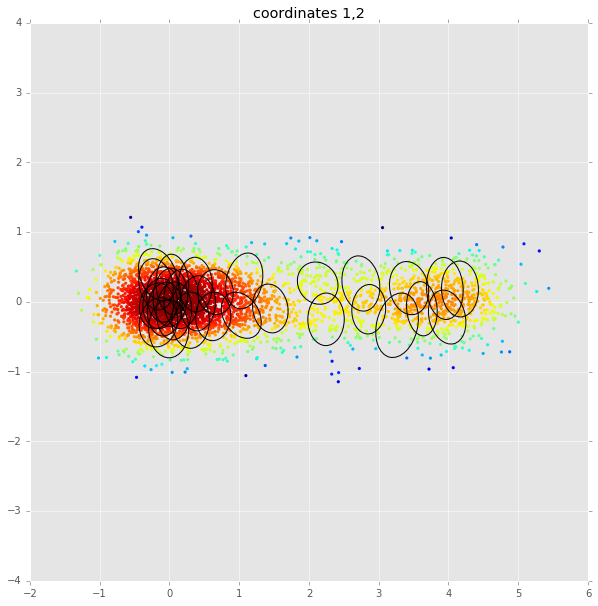

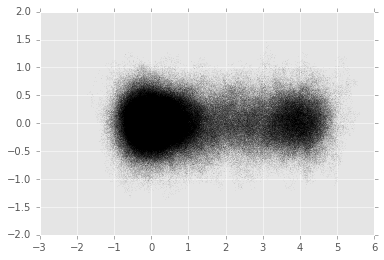

In [181]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps*4)
subsampling = 200
hmm_expects_model = hmm_with_sub_sample(subsampling)

## Subsampling the same trajectory with different number of points.


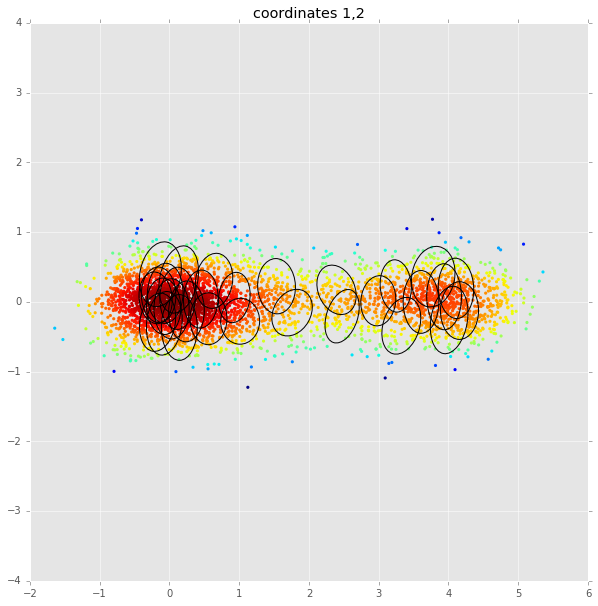

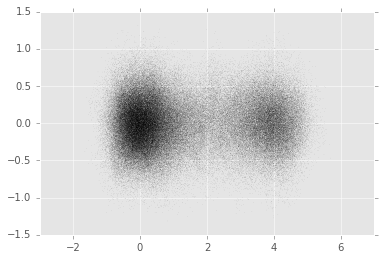

In [200]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
subsampling = 50
hmm_expects_model = hmm_with_sub_sample(subsampling)

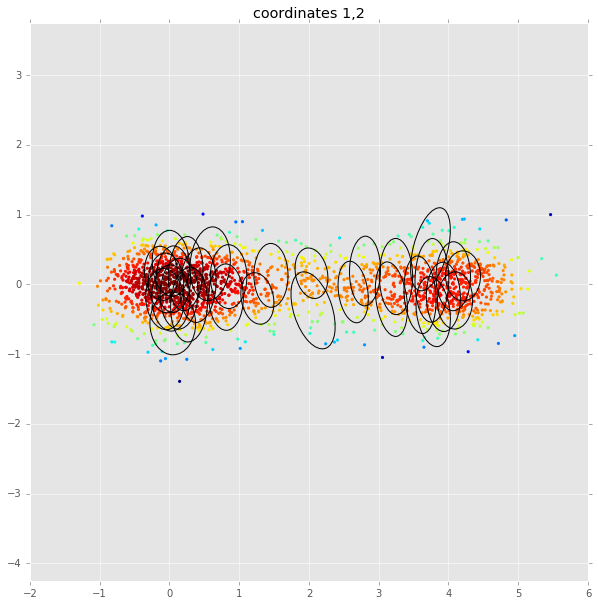

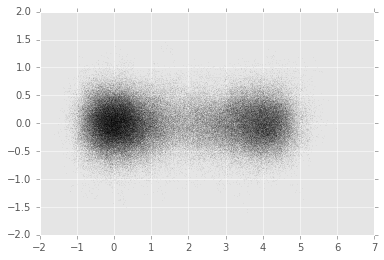

In [216]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
subsampling = 100
hmm_expects_model = hmm_with_sub_sample(subsampling)

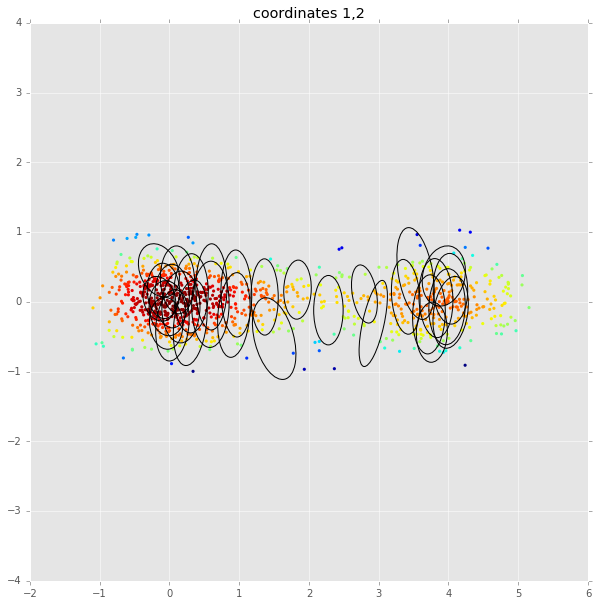

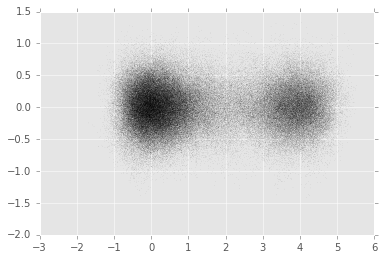

In [208]:
grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
dU = sympy.lambdify([x1,x2],grad_U)
result = run_SDE(dU,T,timesteps)
subsampling = 200
hmm_expects_model = hmm_with_sub_sample(subsampling)

## Monitoring trajectories 

### Original trajectory:

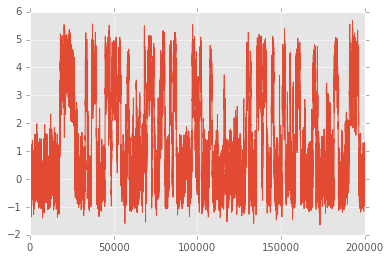

In [202]:
plt.plot(result[:,0]);

### Generated trajectory:

In [203]:
X_obs,X_hidden = hmm_expects_model.sample(timesteps / subsampling)

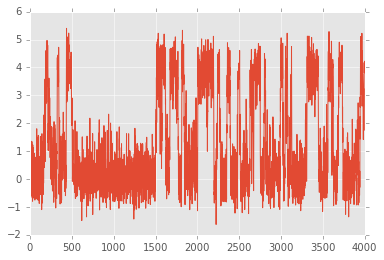

In [204]:
plt.plot(X_obs[:,0]);

# Code snippets

In [348]:
# ### Plot of potential gradient

# grad_U = [sympy.diff(U,x1),sympy.diff(U,x2)]
# grad_U

# dU = sympy.lambdify([x1,x2],grad_U)

# X_range = np.arange(-1,5., .1)
# Y_range = np.arange(-2,2., .1)

# X, Y, = np.meshgrid(X_range, Y_range)

# potential_grad = np.asarray([[dU(x,y) for x in X_range] 
#     for y in Y_range])

# X, Y, = np.meshgrid(X_range, Y_range)
# # U,V = dU_d(X,Y,D)
# u = potential_grad[:,:,0]
# v = potential_grad[:,:,1]

# plt.figure(figsize=(5,5))

# Q = plt.quiver(X, Y, u, v, units='width')

In [ ]:
### Plot density

# x = result.T[0]
# y = result.T[1]

# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# fig = plt.figure(0,)
# fig.set_size_inches(10, 10)
# ax = fig.add_subplot(111, )

# ax.scatter(x, y, c=np.log(z), s=10, edgecolor='')

# Example of using sdeint below

In [77]:
A = np.array([[-0.5, -2.0],
              [ 2.0, -1.0]])

B = np.diag([1.,1.]) # diagonal, so independent driving Wiener processes

tspan = np.linspace(0.0, 10.0, 10001)
x0 = np.array([3.0, 3.0])

def f(x, t):
    return A.dot(x)

def G(x, t):
    return B

result = sdeint.itoint(f, G, x0, tspan,normalized=False)

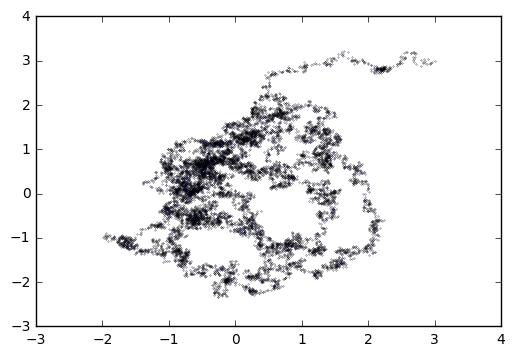

In [78]:
plt.scatter(*result.T,s=0.05)